In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import torch
from torch.autograd import Variable
from torch import Tensor
import io
import requests


tqdm().pandas()
%matplotlib notebook


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [8]:
df = pd.read_csv('data/yellow_tripdata_2009-01.csv', chunksize=50000)

In [9]:
h = next(df)

In [10]:
h.columns

Index(['vendor_name', 'Trip_Pickup_DateTime', 'Trip_Dropoff_DateTime',
       'Passenger_Count', 'Trip_Distance', 'Start_Lon', 'Start_Lat',
       'Rate_Code', 'store_and_forward', 'End_Lon', 'End_Lat', 'Payment_Type',
       'Fare_Amt', 'surcharge', 'mta_tax', 'Tip_Amt', 'Tolls_Amt',
       'Total_Amt'],
      dtype='object')

In [11]:
cols = ['Trip_Pickup_DateTime', 'Trip_Dropoff_DateTime', 'Trip_Distance','Start_Lon',
        'Start_Lat','End_Lon','End_Lat']
h = h[cols]

def filter_coords(df):
    lon_l, lon_r = -74.1, -73.7
    lat_l, lat_r = 40.65, 40.85

    for c in filter(lambda c: c.endswith('_Lon'), df.columns):
        df = df[(df[c] <= lon_r) & (df[c] >= lon_l)]

    for c in filter(lambda c: c.endswith('_Lat'), df.columns):
        df = df[(df[c] <= lat_r) & (df[c] >= lat_l)]

    return df

h = filter_coords(h)

In [12]:
h

,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Trip_Distance,Start_Lon,Start_Lat,End_Lon,End_Lat
0,2009-01-04 02:52:00,2009-01-04 03:02:00,2.63,-73.991957,40.721567,-73.993803,40.695922
1,2009-01-04 03:31:00,2009-01-04 03:38:00,4.55,-73.982102,40.736290,-73.955850,40.768030
2,2009-01-03 15:43:00,2009-01-03 15:57:00,10.35,-74.002587,40.739748,-73.869983,40.770225
3,2009-01-01 20:52:58,2009-01-01 21:14:00,5.00,-73.974267,40.790955,-73.996558,40.731849
4,2009-01-24 16:18:23,2009-01-24 16:24:56,0.40,-74.001580,40.719382,-74.008378,40.720350
5,2009-01-16 22:35:59,2009-01-16 22:43:35,1.20,-73.989806,40.735006,-73.985021,40.724494
6,2009-01-21 08:55:57,2009-01-21 09:05:42,0.40,-73.984050,40.743544,-73.980260,40.748926
7,2009-01-04 04:31:00,2009-01-04 04:36:00,1.72,-73.992635,40.748362,-73.995585,40.728307
8,2009-01-05 16:29:02,2009-01-05 16:40:21,1.60,-73.969690,40.749244,-73.990413,40.751082
9,2009-01-05 18:53:13,2009-01-05 18:57:45,0.70,-73.955173,40.783044,-73.958598,40.774822


<IPython.core.display.Javascript object>


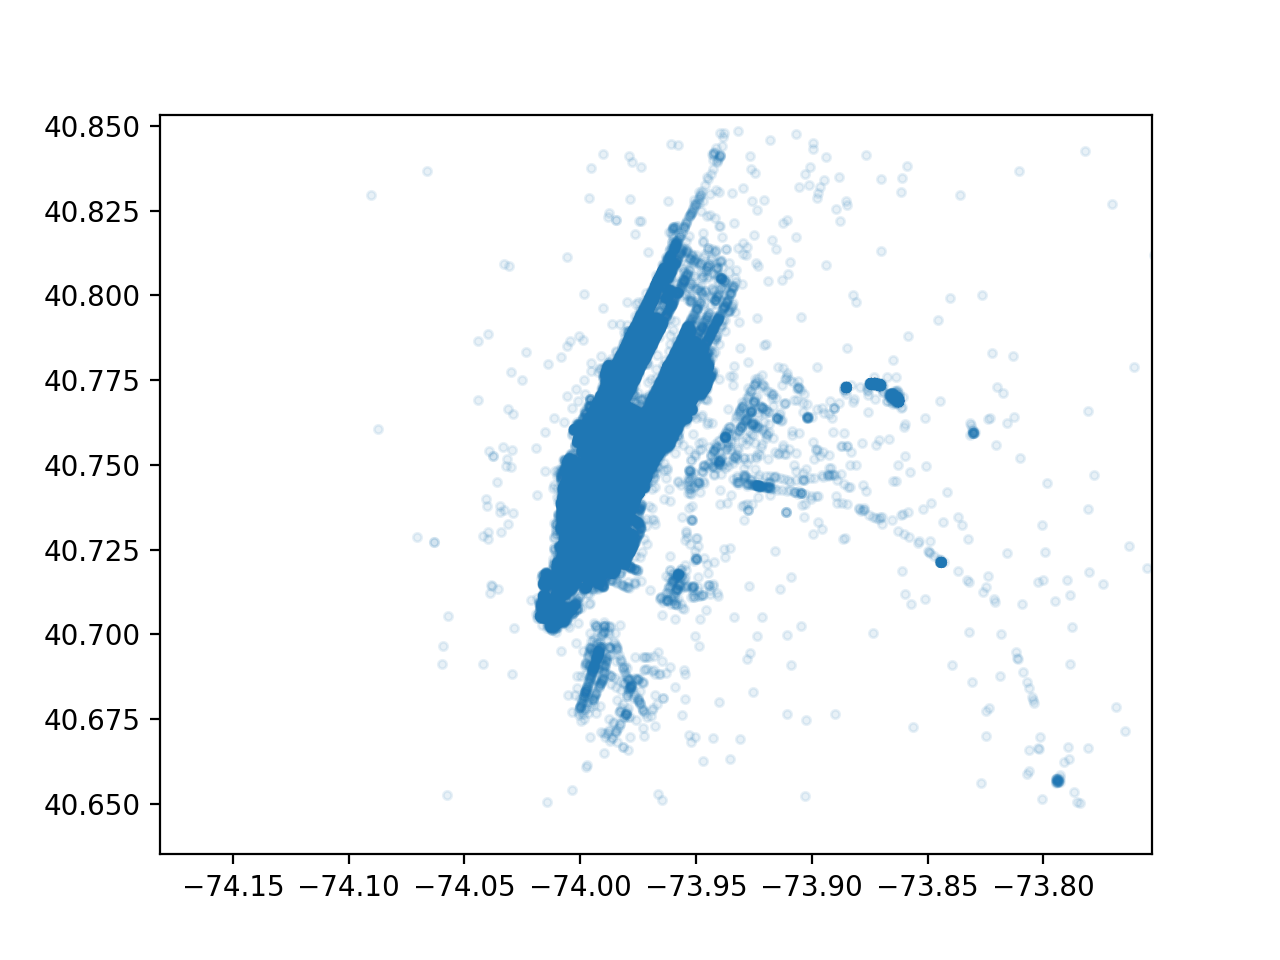

In [13]:
# lon_l, lon_r = -74.1, -73.7
# lat_l, lat_r = 40.65, 40.85

plt.plot(h['Start_Lon'],h['Start_Lat'],'.', alpha=0.1)
# plt.xlim((lon_l, lon_r))
# plt.ylim((lat_l, lat_r))
